# Predicting sales by customer and product

In this kernel, I will attempt to predict two things. First, I will try to predict the number of buys each customer has made. Then, I will try to predict the number of sales on a product basis. Let's see what we get. I will also use PCA to decompose the two and see if we can see something out of the PCA-decomposition - both a linear based one, and a kernel-based PCA. 

First, let us load in all the packages. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import uniform, reciprocal, randint
import xgboost
from sklearn.decomposition import KernelPCA
import seaborn as sns


scale = True
n_bins = 10
n_components = 2

scaler = StandardScaler()

def cross_val_score_log_form(estimator, X, y, cv = 5):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    kf = KFold(n_splits=cv)
    errs = list()
    for train_index, test_index in kf.split(X): #
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        y_hat = estimator.fit(X_train,y_train).predict(X_test)
        errs.append(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_hat))))
    return(errs)


/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cella

## Feature engineering and data processing

In order to do this, I will need to create two data frames, one first for customers, secondly one for the products. Let's start.  

In [2]:
data = pd.read_csv("BlackFriday.csv")
# Replace gender with 1 and -1
data['Gender'] = data['Gender'].replace({'M':1,'F':-1})
data = pd.concat([data,pd.get_dummies(data['City_Category'])],axis=1)
data = data.rename(index=str, columns = {'A':'City A', 'B':'City B', 'C': 'City C'})
data['Age group'] = data['Age'].replace(list(data['Age'].value_counts().sort_index().index), 1+np.arange(len(list(data['Age'].value_counts().sort_index().index))))
data = data.drop(['Age'], axis = 1)
# Create dummies
# Fill product category 2 and 3 with 0s
data['Product_Category_2'] = data['Product_Category_2'].fillna(0)
data['Product_Category_3'] = data['Product_Category_3'].fillna(0)
data['Product_Category_1'] = data['Product_Category_1'].astype("int").astype("category")
data['Product_Category_2'] = data['Product_Category_2'].astype("int").astype("category")
data['Product_Category_3'] = data['Product_Category_3'].astype("int").astype("category")
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].replace({"4+":"4"}).astype("int")
data.head()

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City A,City B,City C,Age group
0,1000001,P00069042,-1,10,A,2,0,3,0,0,8370,1,0,0,1
1,1000001,P00248942,-1,10,A,2,0,1,6,14,15200,1,0,0,1
2,1000001,P00087842,-1,10,A,2,0,12,0,0,1422,1,0,0,1
3,1000001,P00085442,-1,10,A,2,0,12,14,0,1057,1,0,0,1
4,1000002,P00285442,1,16,C,4,0,8,0,0,7969,0,0,1,7


### Customers dataframe

In [3]:

# Create customers dataframe
customers = pd.DataFrame()
customers['User_ID'] = data['User_ID'].unique()

customers = pd.DataFrame(data[['User_ID','Gender','Age group','Occupation','Stay_In_Current_City_Years', 'Marital_Status','City_Category']].drop_duplicates(subset=['User_ID','Gender'],keep="first").sort_values(by='User_ID')).reset_index().drop(["index"],axis = 1)



customers['N buys'] = data.groupby("User_ID").count().reset_index()['Gender']
customers = customers.reset_index().iloc[:,1:]
customers['Purchase'] = data.groupby('User_ID').sum().sort_values(by="User_ID")['Purchase'].values
customers.Stay_In_Current_City_Years = customers.Stay_In_Current_City_Years.replace(list(customers.Stay_In_Current_City_Years.value_counts().sort_index().index), np.arange(customers.Stay_In_Current_City_Years.value_counts().sort_index().shape[0]))
customers.Occupation = customers.Occupation.astype("str")
customers = pd.get_dummies(customers)

dividing_bins = np.concatenate((np.arange(min(np.log(customers['Purchase'])),max(np.log(customers['Purchase'])),(max(np.log(customers['Purchase'])) - min(np.log(customers['Purchase'])))/n_bins),np.array([20])))
customers['Purchase_group'] = pd.cut(np.log(customers['Purchase']), bins = dividing_bins)
customers['logged_purchase'] = np.log(customers['Purchase'])


targets_customers = ["logged_purchase", "Purchase_group", "Purchase", "N buys"]

features = customers.drop(targets_customers+["User_ID"],axis=1).columns


customers.head()

,User_ID,Gender,Age group,Stay_In_Current_City_Years,Marital_Status,N buys,Purchase,Occupation_0,Occupation_1,Occupation_10,...,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,City_Category_A,City_Category_B,City_Category_C,Purchase_group,logged_purchase
0,1000001,-1,1,2,0,34,333481,0,0,1,...,0,0,0,0,0,1,0,0,"(12.337, 12.885]",12.717341
1,1000002,1,7,4,0,76,810353,0,0,0,...,0,0,0,0,0,0,0,1,"(13.432, 13.98]",13.605225
2,1000003,1,3,3,0,29,341635,0,0,0,...,0,0,0,0,0,1,0,0,"(12.337, 12.885]",12.741498
3,1000004,1,5,2,1,13,205987,0,0,0,...,0,0,1,0,0,0,1,0,"(11.79, 12.337]",12.235568
4,1000005,1,3,1,1,106,821001,0,0,0,...,0,0,0,0,0,1,0,0,"(13.432, 13.98]",13.618280


### Products dataframe

In [4]:
products = pd.DataFrame()
n_prod_categories = 18

prod_IDs_by_customer = pd.concat([pd.DataFrame(data['User_ID']),pd.get_dummies(data[['Product_Category_1','Product_Category_2','Product_Category_3']])], axis = 1)
cols_to_drop = prod_IDs_by_customer.columns
for j in range(n_prod_categories):
    prod_IDs_by_customer['Prod_Cat_'+str(j+1)] = prod_IDs_by_customer['Product_Category_1_'+str(j+1)]
    try:
        prod_IDs_by_customer['Prod_Cat_'+str(j+1)] = prod_IDs_by_customer['Prod_Cat_'+str(j+1)] + prod_IDs_by_customer['Product_Category_2_'+str(j+1)]
    except:
        print('Product_Category_2_'+str(j+1)+" not found")
    try:
        prod_IDs_by_customer['Prod_Cat_'+str(j+1)] = prod_IDs_by_customer['Prod_Cat_'+str(j+1)] + prod_IDs_by_customer['Product_Category_3_'+str(j+1)]
    except:
        print('Product_Category_3_'+str(j+1)+" not found")
prod_IDs_by_customer = prod_IDs_by_customer.groupby("User_ID").sum().reset_index()
prod_IDs_by_customer = prod_IDs_by_customer.drop(cols_to_drop, axis=1)


prod_IDs_by_customer.columns
n_prod_categories = 18
cols_to_drop = prod_IDs_by_customer.columns
products = data.groupby("Product_ID").sum().reset_index()[['Product_ID','Purchase']]
products['N sales'] = data.groupby("Product_ID").count().reset_index()['User_ID']

products['Perc males buying'] = (data.groupby("Product_ID").mean()['Gender']/2 + 0.5).reset_index()['Gender']


products['Avg_City_Tenure'] = data.groupby("Product_ID").mean().reset_index()['Stay_In_Current_City_Years']
products['Avg_Age'] = data.groupby("Product_ID").mean().reset_index()['Age group']
products['Buys City A'] = data.groupby("Product_ID").sum().reset_index()['City A']
products['Buys City B'] = data.groupby("Product_ID").sum().reset_index()['City B']
products['Buys City C'] = data.groupby("Product_ID").sum().reset_index()['City C']
products['Married fraction'] = data.groupby("Product_ID").mean().reset_index()['Marital_Status']
products.shape
products['Buys City A'] = products['Buys City A']/products['Buys City A'].sum()
products['Buys City B'] = products['Buys City B']/products['Buys City B'].sum()
products['Buys City C'] = products['Buys City C']/products['Buys City C'].sum()
prod_occupations = pd.concat([data[["User_ID","Product_ID"]],pd.get_dummies(data['Occupation'].astype("category"))], axis = 1).groupby("Product_ID").sum().reset_index().iloc[:,2:].apply(lambda x : x/sum(x))
prod_occupations.columns = ["Fraction Occupation "+str(x) for x in range(prod_occupations.shape[1])]
products = pd.concat([products,prod_occupations],axis = 1)
targets_products = ['N sales', "Purchase"]
products.head()

Product_Category_2_1 not found
Product_Category_3_1 not found
Product_Category_3_2 not found
Product_Category_3_7 not found


,Product_ID,Purchase,N sales,Perc males buying,Avg_City_Tenure,Avg_Age,Buys City A,Buys City B,Buys City C,Married fraction,...,Fraction Occupation 11,Fraction Occupation 12,Fraction Occupation 13,Fraction Occupation 14,Fraction Occupation 15,Fraction Occupation 16,Fraction Occupation 17,Fraction Occupation 18,Fraction Occupation 19,Fraction Occupation 20
0,P00000142,12592163,1130,0.697345,1.792920,3.252212,0.001687,0.001894,0.002746,0.375221,...,0.001323,0.002334,0.001060,0.002358,0.002201,0.001614,0.002149,0.001533,0.001676,0.001914
1,P00000242,3914901,371,0.760108,1.916442,3.296496,0.000567,0.000781,0.000673,0.369272,...,0.000441,0.000723,0.000132,0.000524,0.000593,0.000686,0.000665,0.001073,0.000718,0.000547
2,P00000342,1261383,238,0.718487,1.777311,3.504202,0.000429,0.000433,0.000469,0.399160,...,0.000353,0.000329,0.000795,0.000374,0.000254,0.000645,0.000384,0.000613,0.000479,0.000304
3,P00000442,441173,92,0.500000,1.804348,3.217391,0.000249,0.000168,0.000108,0.413043,...,0.000000,0.000230,0.000132,0.000112,0.000085,0.000081,0.000153,0.000000,0.000239,0.000122
4,P00000542,791219,146,0.657534,2.013699,3.178082,0.000290,0.000305,0.000210,0.308219,...,0.000000,0.000197,0.000000,0.000262,0.000000,0.000161,0.000128,0.000307,0.000359,0.000273


Above, I created a few features. 

- N sales, being the total number of sales for each product. 
- Perc males buying, the fraction between males and females buying. 1 means only males have bought the product. 
- Avg_Age is the Average of the age group. 
- Avg_City_Tenure is the number of years living in the City. 
- Buys City X (3 columns) is the product's percentage out of the total number of products that has been sold in that specific city. 
- Fraction Occupation X is the product's percentage out of the the total number of products that the customers within that occupation has bought. 

## Analysis further modifications

### Customer data analysis

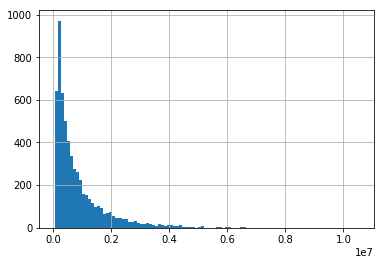

In [5]:
customers['Purchase'].hist(bins=100)

As we can see, the data is highly skewed for the purchase variable, which might lead to problems in the prediction. Therefore, one might like to skew the variable by logarithmizing it to obtain a less skewed distribution, which is beneficial in Linear Regression. 

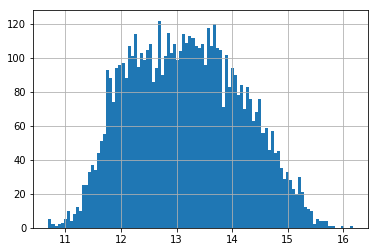

In [6]:
np.log(customers['Purchase']).hist(bins=100)

In [7]:
target = 'N buys'

scaler = StandardScaler()
kernel_pca = KernelPCA(n_components=n_components, kernel = "linear",degree = 2)

#### PCA decomposition 

Let us see if we can see a clear pattern in the customers by visualizing them with the use of PCA. We decompose both in 2 and 3 dimensions, and use the response variable as colour scaling. 

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


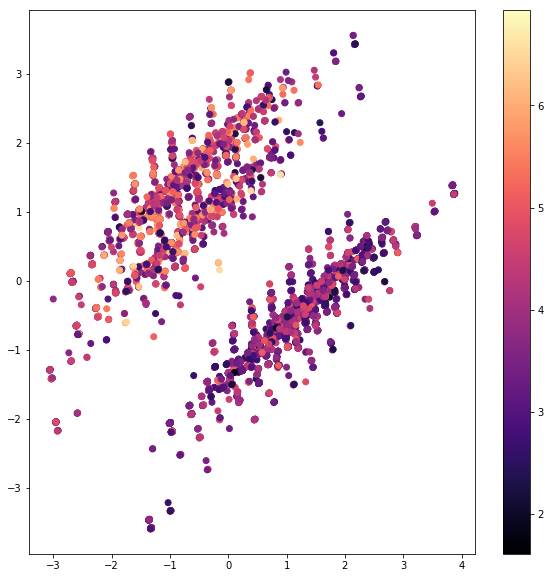

In [8]:

n_components = 2

principalComponents = kernel_pca.fit_transform(pd.DataFrame(scaler.fit_transform(customers.drop(targets_customers+["User_ID"], axis = 1))))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC'+str(i+1) for i in range(n_components)])
finalDf = pd.concat([principalDf, np.log(customers[target])], axis = 1)
finalDf.columns = ['PC'+str(i+1) for i in range(n_components)]+['target']
finalDf.head()


cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(finalDf['target']), vmax=max(finalDf['target']))
colors = [cmap(normalize(value)) for value in finalDf['target']]


fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(finalDf['PC1'], finalDf['PC2'], color=colors)
cax, kw = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


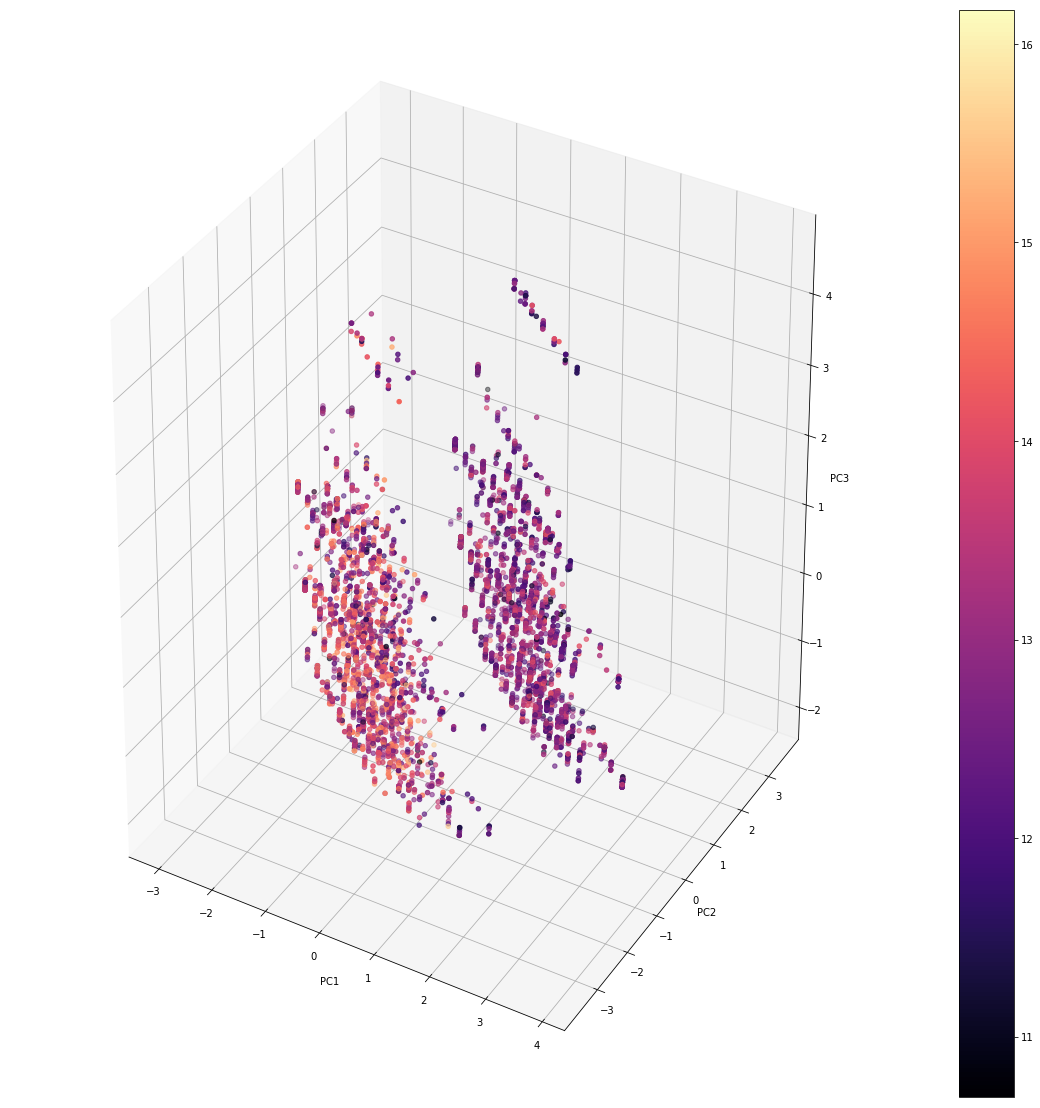

In [9]:
n_components = 3
target = 'logged_purchase'

scaler = StandardScaler()
kernel_pca = KernelPCA(n_components=n_components, kernel = "linear",degree = 2)


principalComponents = kernel_pca.fit_transform(pd.DataFrame(scaler.fit_transform(customers.drop(targets_customers+["User_ID"], axis = 1))))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC'+str(i+1) for i in range(n_components)])
finalDf = pd.concat([principalDf, customers[target]], axis = 1)
finalDf.columns = ['PC'+str(i+1) for i in range(n_components)]+['target']
finalDf.head()
# Now we try to picture it

cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(finalDf['target']), vmax=max(finalDf['target']))
colors = [cmap(normalize(value)) for value in finalDf['target']]


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(finalDf['PC1'], finalDf['PC2'], finalDf['PC3'], c=colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
cax, kw = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

There is a relatively clear pattern - one cluster seems to be buying more than another cluster. 

### Product data analysis - skewedness

Let us see if we can fix the skewedness, which is a big problem when working with linear models. 

In [10]:

# Taken from Yassine Ghouzam@Kaggle
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

<Figure size 432x288 with 0 Axes>

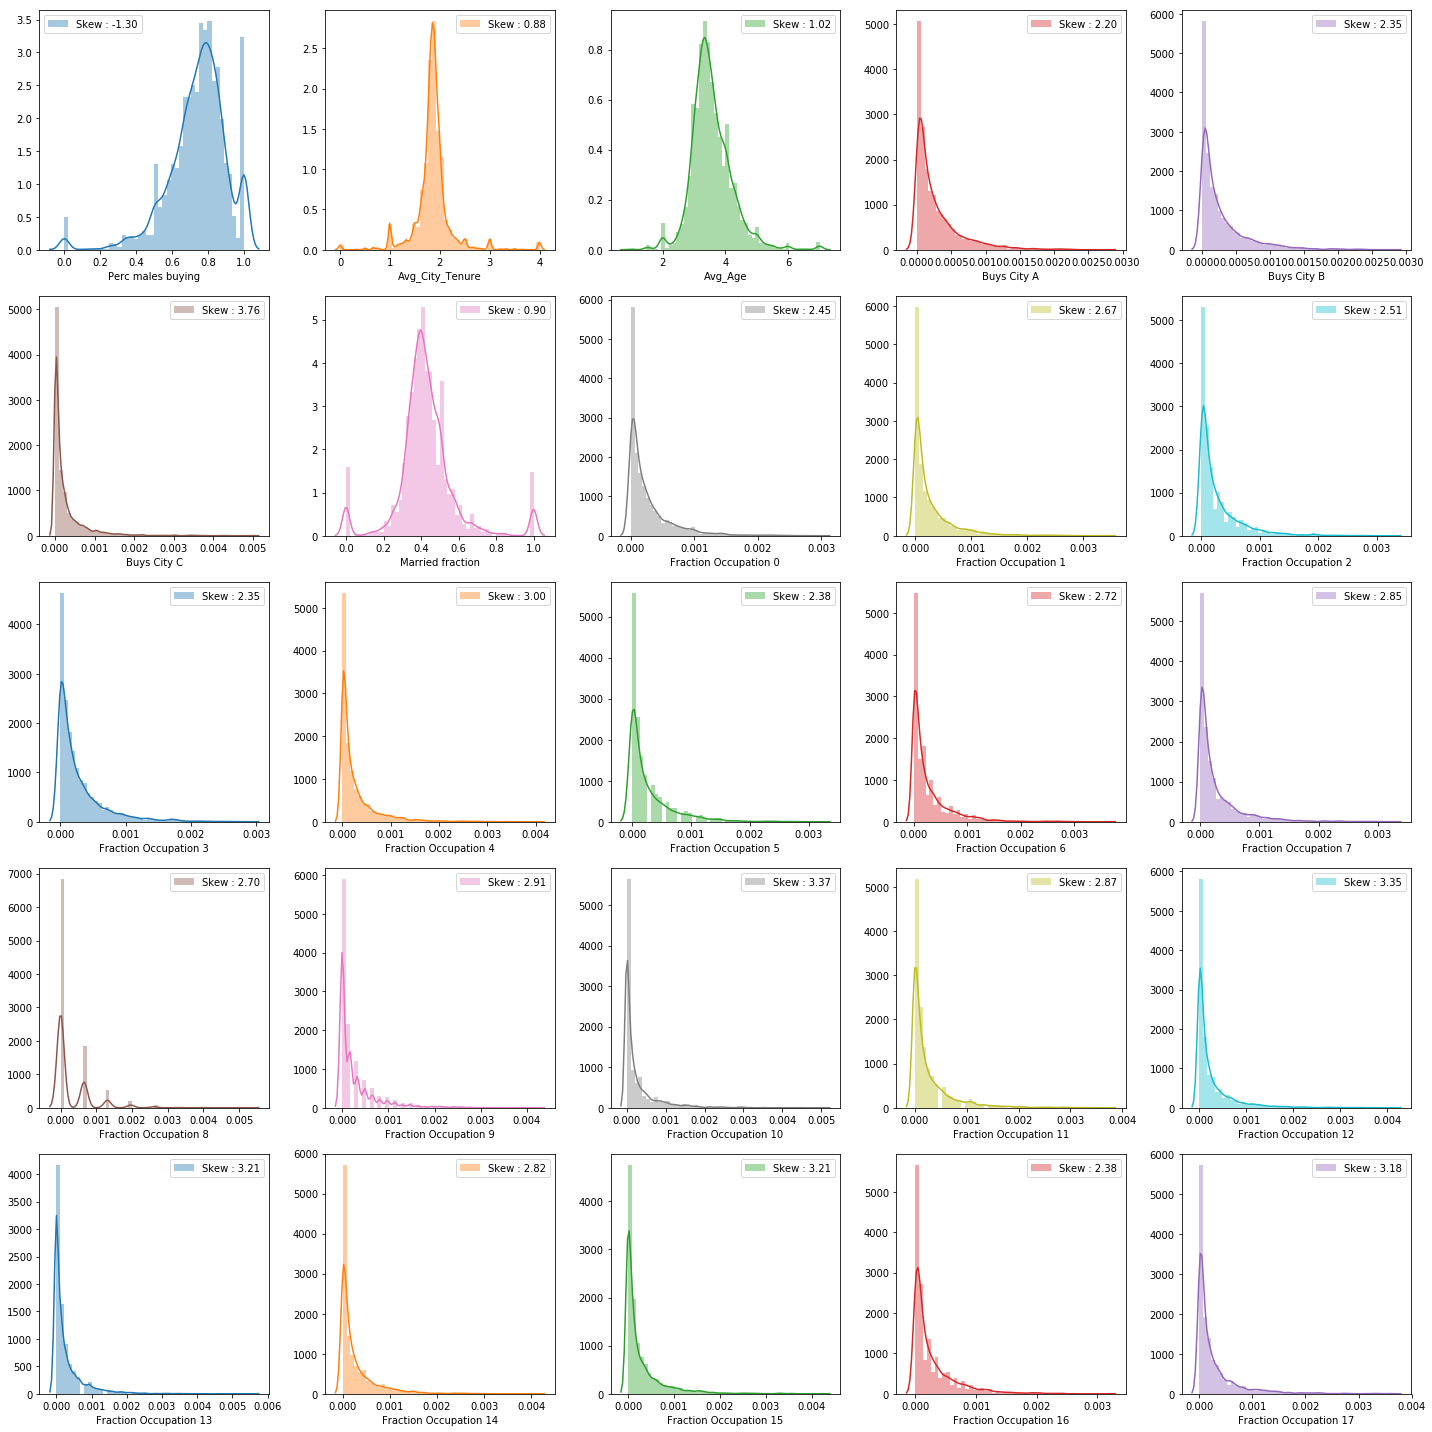

<Figure size 432x288 with 0 Axes>

In [11]:
multiplot(data = products, features = products.drop(targets_products+["Product_ID"], axis = 1).columns, plottype = "distplot", nrows = 5, ncols = 5, figsize = (20,20),colorize = True)

In [12]:

features = products.drop(targets_products+["Product_ID"],axis=1).columns


for feature in features:
    if feature not in targets_products+["Product_ID"] and np.abs(products[feature].skew()) > 1:
        products[feature] = np.log1p(products[feature])


In [13]:
target = 'N sales'

scaler = StandardScaler()

X_products = products.drop(targets_products+["Product_ID"],axis=1)

/usr/local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


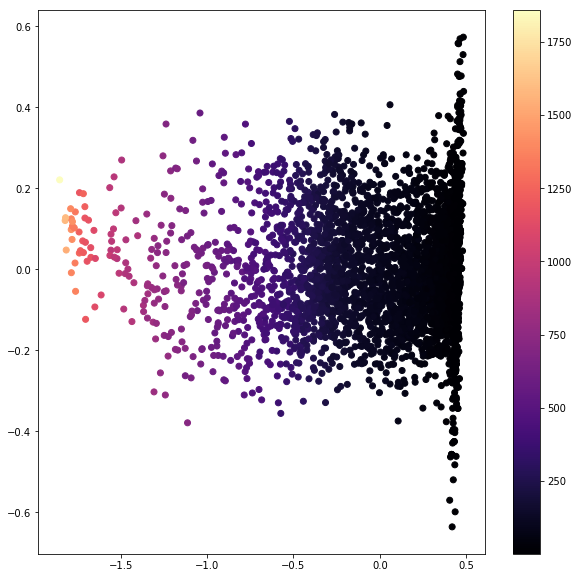

In [14]:
n_components = 2
kernel_pca = KernelPCA(n_components=n_components, kernel = "sigmoid")
principalComponents = kernel_pca.fit_transform(pd.DataFrame(scaler.fit_transform(X_products)))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC'+str(i+1) for i in range(n_components)])
finalDf = pd.concat([principalDf, products[target]], axis = 1)
finalDf.columns = ['PC'+str(i+1) for i in range(n_components)]+['target']
# Now we try to picture it

cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(finalDf['target']), vmax=max(finalDf['target']))
colors = [cmap(normalize(value)) for value in finalDf['target']]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(finalDf['PC1'], finalDf['PC2'], color=colors)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

Above, as well as below, we see a clear pattern and relation between PC1 and N Buys. We should be able to use this. 

/usr/local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


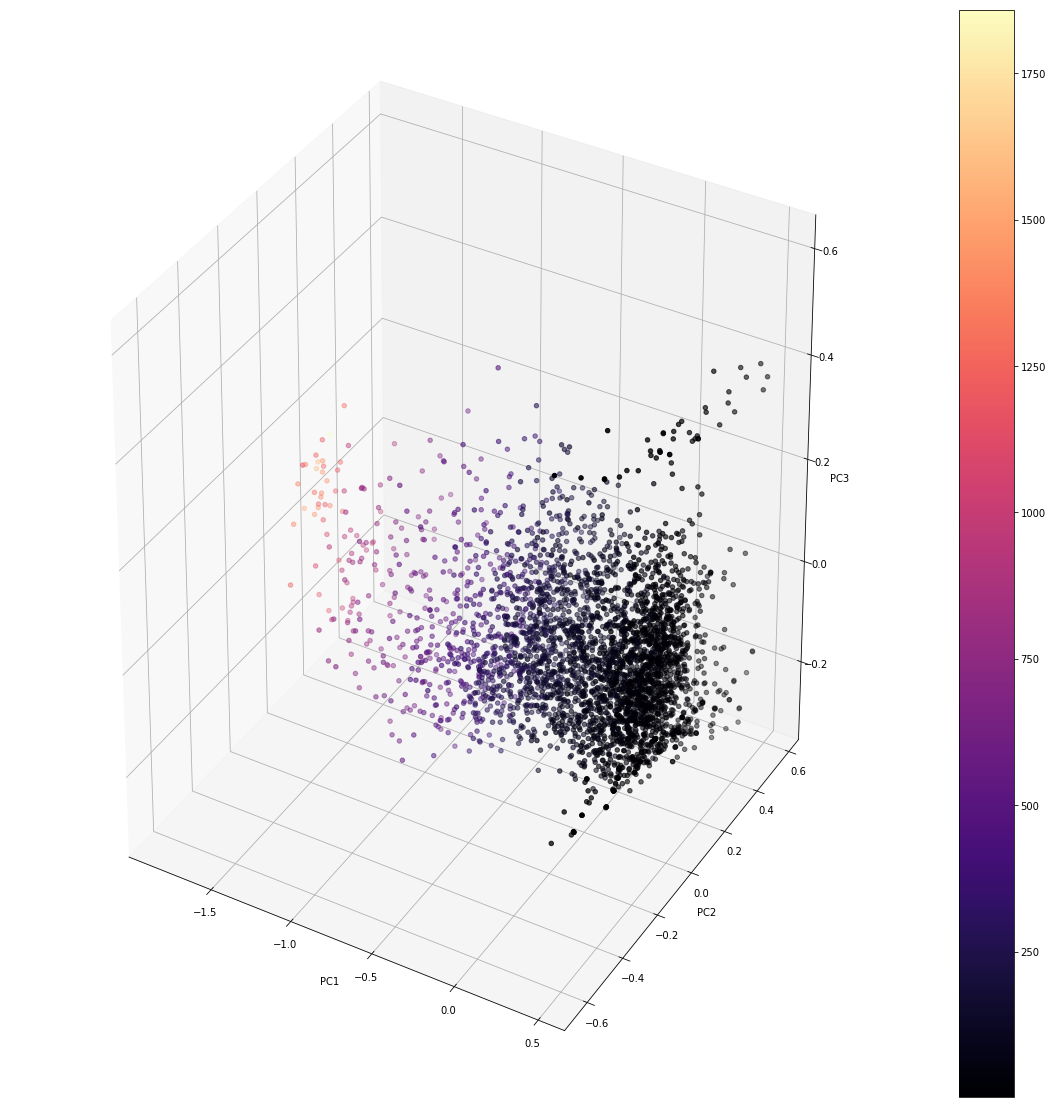

In [15]:
n_components = 3
target = 'N sales'

kernel_pca = KernelPCA(n_components=n_components, kernel = "sigmoid")
X_products.columns

principalComponents = kernel_pca.fit_transform(pd.DataFrame(scaler.fit_transform(X_products)))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC'+str(i+1) for i in range(n_components)])
finalDf = pd.concat([principalDf, products[target]], axis = 1)
finalDf.columns = ['PC'+str(i+1) for i in range(n_components)]+['target']
finalDf.head()

cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(finalDf['target']), vmax=max(finalDf['target']))
colors = [cmap(normalize(value)) for value in finalDf['target']]


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(finalDf['PC1'], finalDf['PC2'], finalDf['PC3'], c=colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

## Predicting

### Predicting the number of buys for each customer

In [16]:

target = "N buys"

X = customers.drop(targets_customers+["User_ID"],axis=1)
y = customers[target]

X_scaled = pd.DataFrame(scaler.fit_transform(X))

print("Linear regression log form: ",np.mean(cross_val_score_log_form(LinearRegression(),X,np.log(y),cv=10)))
print("XGBoost log form: ",np.mean(cross_val_score_log_form(XGBRegressor(),X_scaled,np.log(y),cv=10)))
print("Huber regression log form: ",np.mean(cross_val_score_log_form(HuberRegressor(),X,np.log(y),cv=10)))
print("Linear regression: ",np.mean(np.sqrt(np.abs(cross_val_score(LinearRegression(),X_scaled,y,cv=10,scoring='neg_mean_squared_error')))))
print("Huber regression log form: ",np.mean(np.sqrt(np.abs(cross_val_score(HuberRegressor(),X,y,cv=10,scoring='neg_mean_squared_error')))))
print("XGBoost: ",np.mean(np.sqrt(np.abs(cross_val_score(XGBRegressor(),X,y,cv=10,scoring='neg_mean_squared_error')))))


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Linear regression log form:  103.66455186303196
XGBoost log form:  103.37122459781838
Huber regression log form:  103.05673781498119
Linear regression:  97.21620621793835
Huber regression log form:  101.52961549769906
XGBoost:  96.80022900956885


### Predicting the number of sales for each product

In [17]:

target = "N sales"

X_products = products.drop(targets_products+["Product_ID"],axis=1)
y_products = products[target]

print("Linear Regression: ",np.mean(np.sqrt(np.abs(cross_val_score(LinearRegression(),X_products,y_products,cv=10,scoring='neg_mean_squared_error')))))
print("XGBoost: ",np.mean(np.sqrt(np.abs(cross_val_score(XGBRegressor(),X_products,y_products,cv=10,scoring='neg_mean_squared_error')))))
print("XGBoost log form: ",np.mean(np.abs(cross_val_score_log_form(XGBRegressor(),X_products,np.log(y_products),cv=10))))


Linear Regression:  0.041768080613118486
XGBoost:  6.666811041948843
XGBoost log form:  9.4478246794291


It seems like there is a data leakage, as the results are just too good. We should probably drop the columns that are probable to cause the data leakage and see if the results are still as good. 

In [18]:
products.columns

Index(['Product_ID', 'Purchase', 'N sales', 'Perc males buying',
       'Avg_City_Tenure', 'Avg_Age', 'Buys City A', 'Buys City B',
       'Buys City C', 'Married fraction', 'Fraction Occupation 0',
       'Fraction Occupation 1', 'Fraction Occupation 2',
       'Fraction Occupation 3', 'Fraction Occupation 4',
       'Fraction Occupation 5', 'Fraction Occupation 6',
       'Fraction Occupation 7', 'Fraction Occupation 8',
       'Fraction Occupation 9', 'Fraction Occupation 10',
       'Fraction Occupation 11', 'Fraction Occupation 12',
       'Fraction Occupation 13', 'Fraction Occupation 14',
       'Fraction Occupation 15', 'Fraction Occupation 16',
       'Fraction Occupation 17', 'Fraction Occupation 18',
       'Fraction Occupation 19', 'Fraction Occupation 20'],
      dtype='object')

In [19]:
to_drop = ['Buys City A', 'Buys City B', 'Buys City C'] + ['Fraction Occupation '+str(i) for i in range(21)]
X_products = products.drop(targets_products+["Product_ID"]+to_drop,axis=1)

In [20]:
print("Linear Regression: ",np.mean(np.sqrt(np.abs(cross_val_score(LinearRegression(),X_products,y_products,cv=10,scoring='neg_mean_squared_error')))))
print("XGBoost: ",np.mean(np.sqrt(np.abs(cross_val_score(XGBRegressor(),X_products,y_products,cv=10,scoring='neg_mean_squared_error')))))
print("XGBoost log form: ",np.mean(np.abs(cross_val_score_log_form(XGBRegressor(),X_products,np.log(y_products),cv=10))))


Linear Regression:  203.02609816761097
XGBoost:  150.7732970729751
XGBoost log form:  160.4564266591023


Now, we can see that the results drop significantly. It is of course not surprising, since a lot of columns were removed. Yet, it is important to note that this model is probably better than the other, since it does not have data leakage. 

For all models, the results are fairly poor. I would definitely like some input on what might be a better approach, and some suggestions on further feature engineering. 

This was just a fun kernel I decided to implement and the results are not that great, but if you have further suggestions on what could be done, comment! 